In [1]:
import sys
sys.path.append('/home/jbourbeau/cr-composition')
print('Added to PYTHONPATH')

Added to PYTHONPATH


In [2]:
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn.apionly as sns

from sklearn.metrics import accuracy_score
from sklearn.model_selection import validation_curve, GridSearchCV, cross_val_score, ParameterGrid

import composition as comp
import composition.analysis.plotting as plotting

%matplotlib inline
sns.set_palette('muted')
sns.set_color_codes()

/home/jbourbeau/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


1. Load simulation dataframe and apply specified quality cuts
2. Extract desired features from dataframe
3. Get separate testing and training datasets

In [3]:
df, cut_dict = comp.load_sim(return_cut_dict=True)
selection_mask = np.array([True] * len(df))
standard_cut_keys = ['lap_reco_success', 'lap_zenith', 'num_hits_45_60', 'IT_signal',
                     'StationDensity', 'max_qfrac_45_60', 'lap_containment', 'energy_range_lap']
# standard_cut_keys = ['lap_reco_success', 'lap_zenith', 'num_hits_1_30', 'IT_signal',
#                      'StationDensity', 'max_qfrac_1_30', 'lap_containment', 'energy_range_lap']
# standard_cut_keys = ['reco_exists', 'reco_zenith', 'num_hits_1_60', 'IT_signal',
#                      'StationDensity', 'max_qfrac_1_60', 'reco_containment', 'energy_range']
for key in standard_cut_keys:
    selection_mask *= cut_dict[key]

df = df[selection_mask]

feature_list, feature_labels = comp.get_training_features()
print('training features = {}'.format(feature_list))
X_train, X_test, y_train, y_test, le = comp.get_train_test_sets(
    df, feature_list, train_he=True, test_he=True)

print('number training events = ' + str(y_train.shape[0]))

/home/jbourbeau/cr-composition/composition/load_sim.py:109: RuntimeWarning: divide by zero encountered in log10
  df['log_NChannels_1_30'] = np.nan_to_num(np.log10(df['NChannels_1_30']))


training features = ['lap_log_energy', 'InIce_log_charge_1_30', 'lap_cos_zenith', 'NChannels_1_30', 'log_s125']
number training events = 82408


In [4]:
X_train[:50, 0], le.inverse_transform(y_train)[:50], le.inverse_transform(y_test)[:50]

(array([ 6.44662778,  7.86627784,  6.59962503,  6.82091424,  7.60676344,
         6.21448064,  6.48497238,  6.85217622,  7.56594326,  6.41748673,
         7.69858618,  7.22671799,  6.5288059 ,  6.51230536,  7.14926385,
         7.63684919,  7.14332047,  7.31713482,  7.06631171,  7.8943434 ,
         6.81265567,  6.68914717,  7.94058341,  6.58938898,  6.40761168,
         7.33456581,  7.66660701,  6.81142229,  6.89427767,  7.56391569,
         7.86560961,  7.63907239,  7.92735224,  6.5382236 ,  7.89726147,
         7.43687611,  6.9827456 ,  7.69661523,  6.4335847 ,  6.9182418 ,
         6.5067947 ,  6.84084176,  6.77788941,  6.98240114,  6.59656763,
         6.28196335,  7.75507639,  6.76567171,  6.40263978,  6.31080251]),
 array(['Fe', 'Fe', 'He', 'He', 'He', 'Fe', 'P', 'He', 'He', 'P', 'P', 'Fe',
        'P', 'Fe', 'P', 'Fe', 'P', 'He', 'He', 'He', 'Fe', 'He', 'He', 'He',
        'He', 'P', 'P', 'Fe', 'He', 'P', 'He', 'He', 'Fe', 'Fe', 'Fe', 'P',
        'Fe', 'He', 'He', 'He', 'P', '

Get error in charge vs. energy distribution

In [5]:
len(df)

117727

In [6]:
pipeline = comp.get_pipeline('RF')
param_range = np.arange(1, 31)
param_grid = {'classifier__max_depth': param_range}
gs = GridSearchCV(estimator=pipeline,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=5,
                  verbose=1,
                  n_jobs=20)
gs = gs.fit(X_train, y_train)
print('best GS CV score = {}'.format(gs.best_score_))
print('best GS CV depths = {}'.format(gs.best_params_))
print('Grid scores on development set:')
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gs.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
pipeline.set_params(**gs.best_params_)
pipeline.fit(X_train, y_train)
scaler = pipeline.named_steps['scaler']
clf = pipeline.named_steps['classifier']

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    6.4s
[Parallel(n_jobs=20)]: Done 150 out of 150 | elapsed:  2.0min finished


best GS CV score = 0.600572759926
best GS CV depths = {'classifier__max_depth': 13}
Grid scores on development set:
0.441 (+/-0.004) for {'classifier__max_depth': 1}
0.456 (+/-0.007) for {'classifier__max_depth': 2}
0.515 (+/-0.015) for {'classifier__max_depth': 3}
0.544 (+/-0.013) for {'classifier__max_depth': 4}
0.573 (+/-0.008) for {'classifier__max_depth': 5}
0.585 (+/-0.008) for {'classifier__max_depth': 6}
0.591 (+/-0.007) for {'classifier__max_depth': 7}
0.595 (+/-0.009) for {'classifier__max_depth': 8}
0.597 (+/-0.007) for {'classifier__max_depth': 9}
0.599 (+/-0.010) for {'classifier__max_depth': 10}
0.601 (+/-0.009) for {'classifier__max_depth': 11}
0.600 (+/-0.009) for {'classifier__max_depth': 12}
0.601 (+/-0.008) for {'classifier__max_depth': 13}
0.600 (+/-0.007) for {'classifier__max_depth': 14}
0.600 (+/-0.007) for {'classifier__max_depth': 15}
0.599 (+/-0.007) for {'classifier__max_depth': 16}
0.599 (+/-0.008) for {'classifier__max_depth': 17}
0.598 (+/-0.007) for {'cla

In [7]:
clf_name = clf.__class__.__name__
print('=' * 30)
print(clf_name)
test_predictions = pipeline.predict(X_test)
test_acc = accuracy_score(y_test, test_predictions)
print('Test accuracy: {:.4%}'.format(test_acc))
train_predictions = pipeline.predict(X_train)
train_acc = accuracy_score(y_train, train_predictions)
print('Train accuracy: {:.4%}'.format(train_acc))
scores = cross_val_score(
    estimator=pipeline, X=X_test, y=y_test, cv=10, n_jobs=10)
print('CV score: {:.2%} (+/- {:.2%})'.format(scores.mean(), scores.std()))
print('=' * 30)

RandomForestClassifier
Test accuracy: 60.1263%
Train accuracy: 68.0723%
CV score: 59.52% (+/- 0.96%)


In [8]:
wah = clf.estimators_

In [9]:
decisiontree = clf.estimators_[0]
tree =  decisiontree.tree_
# print(tree.decision_path(X_test.astype(np.float32)))
print(tree.node_count)
print(tree.n_node_samples)
print(tree.apply(X_test.astype(np.float32)))
print(tree.n_node_samples[tree.apply(X_test.astype(np.float32))])
print(tree.children_left)
leaf_samples = []
for tree in clf.estimators_:
    leaf_samples.extend(tree.tree_.n_node_samples[tree.apply(X_test.astype(np.float32))])
print(np.min(leaf_samples))
print(np.max(leaf_samples))

3331
[51993  9995  2436 ...,    96    60    17]
[3330 3330 3330 ..., 3330 3330 3330]
[17 17 17 ..., 17 17 17]
[ 1  2  3 ..., -1 -1 -1]
10
376


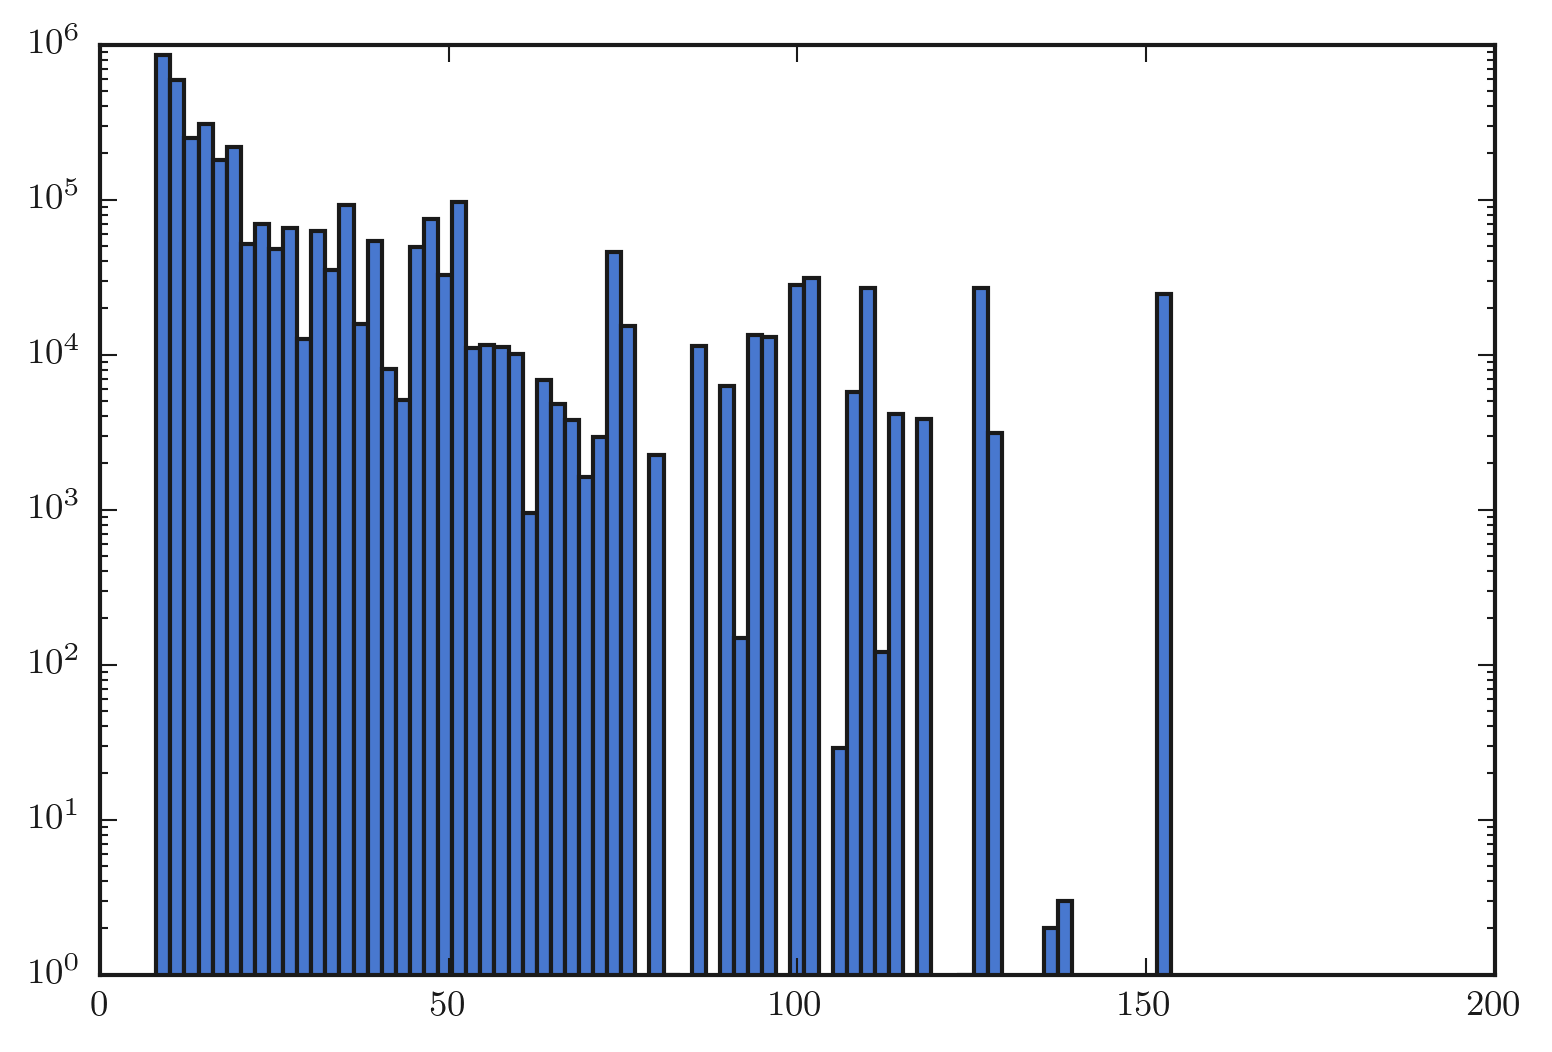

In [10]:
counts, bins, pathches = plt.hist(leaf_samples, bins=np.linspace(0, 200, 100), log=True)

In [11]:
# Using those arrays, we can parse the tree structure:
estimator = clf.estimators_[0]
n_nodes = estimator.tree_.node_count
children_left = estimator.tree_.children_left
children_right = estimator.tree_.children_right
feature = estimator.tree_.feature
threshold = estimator.tree_.threshold


# The tree structure can be traversed to compute various properties such
# as the depth of each node and whether or not it is a leaf.
node_depth = np.zeros(shape=n_nodes)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)]  # seed is the root node id and its parent depth
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

    # If we have a test node
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True

print("The binary tree structure has %s nodes and has "
      "the following tree structure:"
      % n_nodes)
for i in range(n_nodes):
    if is_leaves[i]:
        print("%snode=%s leaf node." % ("\t", i))
#         print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
#     else:
#         print("%snode=%s test node: go to node %s if X[:, %s] <= %ss else to "
#               "node %s."
#               % (node_depth[i] * "\t",
#                  i,
#                  children_left[i],
#                  feature[i],
#                  threshold[i],
#                  children_right[i],
#                  ))
print()

The binary tree structure has 2933 nodes and has the following tree structure:
	node=10 leaf node.
	node=11 leaf node.
	node=13 leaf node.
	node=16 leaf node.
	node=17 leaf node.
	node=19 leaf node.
	node=20 leaf node.
	node=23 leaf node.
	node=25 leaf node.
	node=26 leaf node.
	node=29 leaf node.
	node=31 leaf node.
	node=32 leaf node.
	node=35 leaf node.
	node=36 leaf node.
	node=38 leaf node.
	node=39 leaf node.
	node=43 leaf node.
	node=45 leaf node.
	node=47 leaf node.
	node=48 leaf node.
	node=51 leaf node.
	node=52 leaf node.
	node=53 leaf node.
	node=57 leaf node.
	node=58 leaf node.
	node=60 leaf node.
	node=62 leaf node.
	node=63 leaf node.
	node=66 leaf node.
	node=67 leaf node.
	node=69 leaf node.
	node=70 leaf node.
	node=75 leaf node.
	node=78 leaf node.
	node=79 leaf node.
	node=81 leaf node.
	node=82 leaf node.
	node=85 leaf node.
	node=87 leaf node.
	node=88 leaf node.
	node=91 leaf node.
	node=92 leaf node.
	node=94 leaf node.
	node=95 leaf node.
	node=100 leaf node.


In [11]:
comp_list = ['P', 'He', 'Fe']
# comp_list = ['P', 'Fe']
# comp_list = le.inverse_transform(np.unique(y_test))

correctly_identified_mask = (test_predictions == y_test)

# Energy-related variables
energy_bin_width = 0.1
energy_bins = np.arange(6.2, 8.1, energy_bin_width)
# energy_bins = np.arange(6.2, 9.51, energy_bin_width)
energy_midpoints = (energy_bins[1:] + energy_bins[:-1]) / 2
log_energy = X_test[:, 0]

# Construct MC composition masks
MC_comp_mask = {}
for composition in comp_list:
    MC_comp_mask[composition] = (le.inverse_transform(y_test) == composition)

# Get number of MC comp in each reco energy bin
num_MC_energy, num_MC_energy_err = {}, {}
for composition in comp_list:
    num_MC_energy[composition] = np.histogram(log_energy[MC_comp_mask[composition]],
                                     bins=energy_bins)[0]
    num_MC_energy_err[composition] = np.sqrt(num_MC_energy[composition])

num_MC_energy['total'] = np.histogram(log_energy, bins=energy_bins)[0]
num_MC_energy_err['total'] = np.sqrt(num_MC_energy['total'])


# Get number of correctly identified comp in each reco energy bin
num_reco_energy, num_reco_energy_err = {}, {}
for composition in comp_list:
    num_reco_energy[composition] = np.histogram(
        log_energy[MC_comp_mask[composition] & correctly_identified_mask],
        bins=energy_bins)[0]
    num_reco_energy_err[composition] = np.sqrt(num_reco_energy[composition])

num_reco_energy['total'] = np.histogram(log_energy[correctly_identified_mask], bins=energy_bins)[0]
num_reco_energy_err['total'] = np.sqrt(num_reco_energy['total'])



# Calculate correctly identified fractions as a function of MC energy
reco_frac, reco_frac_err = {}, {}
for composition in comp_list:
    print(composition)
    reco_frac[composition], reco_frac_err[composition] = comp.ratio_error(
        num_reco_energy[composition], num_reco_energy_err[composition],
        num_MC_energy[composition], num_MC_energy_err[composition])
    
reco_frac['total'], reco_frac_err['total'] = comp.ratio_error(
        num_reco_energy['total'], num_reco_energy_err['total'],
        num_MC_energy['total'], num_MC_energy_err['total'])

P
He
Fe


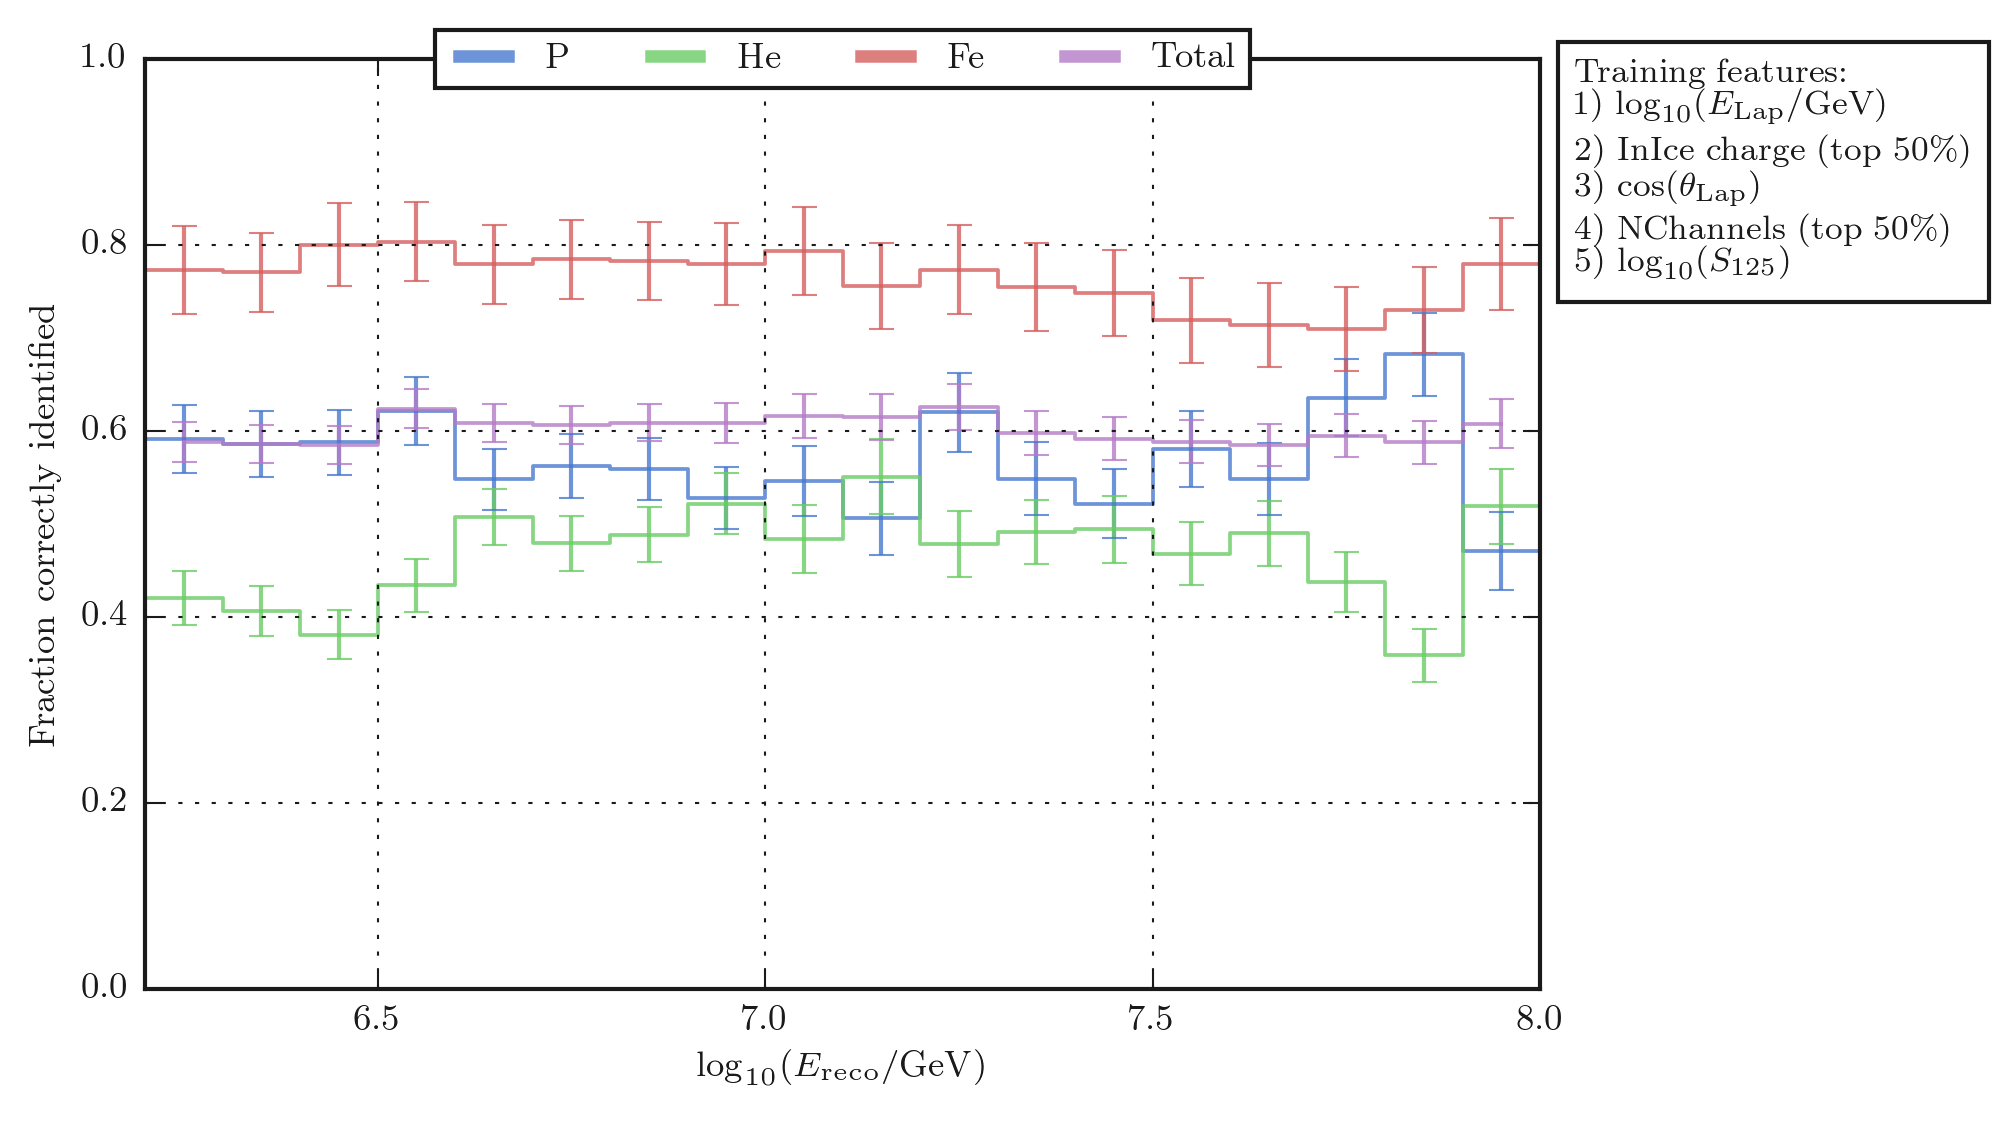

In [12]:
# Plot fraction of events vs energy
fig, ax = plt.subplots()
for composition in comp_list:
    ebar = ax.errorbar(energy_midpoints, reco_frac[composition],
                yerr=reco_frac_err[composition],
                # xerr=energy_bin_width / 2,
                marker=None, markersize=5,
                alpha=0.8)
    step_x = energy_midpoints
    step_x = np.append(step_x[0]-energy_bin_width/2, step_x)
    step_x = np.append(step_x, step_x[-1]+energy_bin_width/2)
    step_y = reco_frac[composition]
    step_y = np.append(step_y[0], step_y)
    step_y = np.append(step_y, step_y[-1])
    ax.step(step_x, step_y, where='mid',
            marker=None, color=ebar[0].get_color(), linewidth=0.9,
            linestyle='-', label=composition, alpha=0.8)
ebar = ax.errorbar(energy_midpoints, reco_frac['total'],
                yerr=reco_frac_err['total'],
                # xerr=energy_bin_width / 2,
                marker=None, markersize=5,
                alpha=0.8)
ax.step(energy_midpoints, reco_frac['total'], where='mid', marker=None,
        color=ebar[0].get_color(), linewidth=0.9, label='Total', alpha=0.8)
plt.xlabel('$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV})$')
ax.set_ylabel('Fraction correctly identified')
ax.set_ylim([0.0, 1.0])
ax.set_xlim([6.2, 8.0])
# ax.set_xlim([6.2, 9.5])
plt.grid()
# leg = plt.legend(loc=3)
leg = plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=len(comp_list)+1, fancybox=False, shadow=False)
# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(3.0)
# place a text box in upper left in axes coords
textstr = 'Training features: \n'
for i, label in enumerate(feature_labels):
    if (i == len(feature_labels)-1):
        textstr += '{}) '.format(i+1) + label
    else:
        textstr += '{}) '.format(i+1) + label + '\n'
# print(textstr)
props = dict(facecolor='white')
# ax.text(0.0, 0.0, textstr, transform=ax.transAxes, fontsize=8,
#         verticalalignment='top', bbox=props)
ax.text(1.025, 1.0, textstr, transform=ax.transAxes, fontsize=8,
        verticalalignment='top', bbox=props)
outfile = '/home/jbourbeau/public_html/figures/composition' + \
          '/fraction-reco-correct_vs_reco-energy_RF.png'
plt.savefig(outfile)
plt.show()

    MC Compositions
P             38151
He            39736
Fe            39840
    after
P   10921
He  11614
Fe  12784


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1922f3d0>], dtype=object)

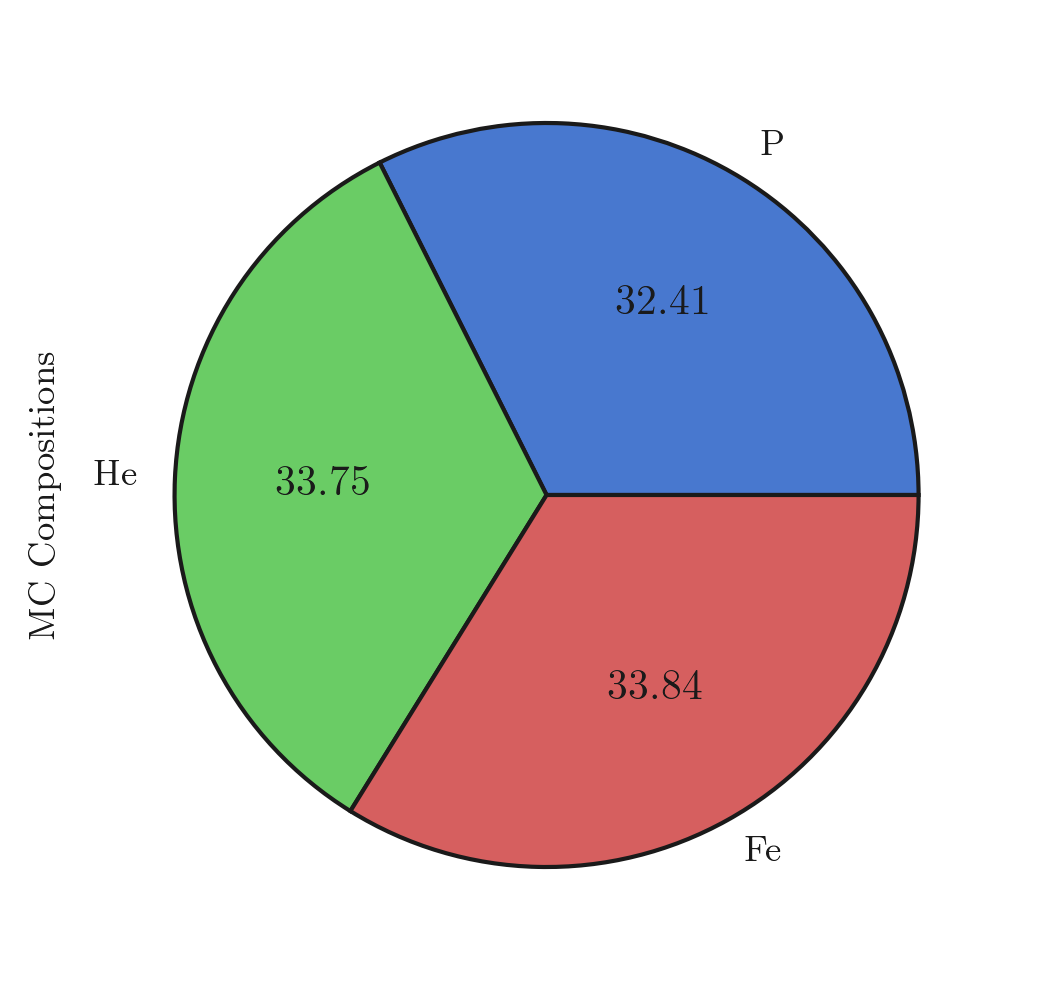

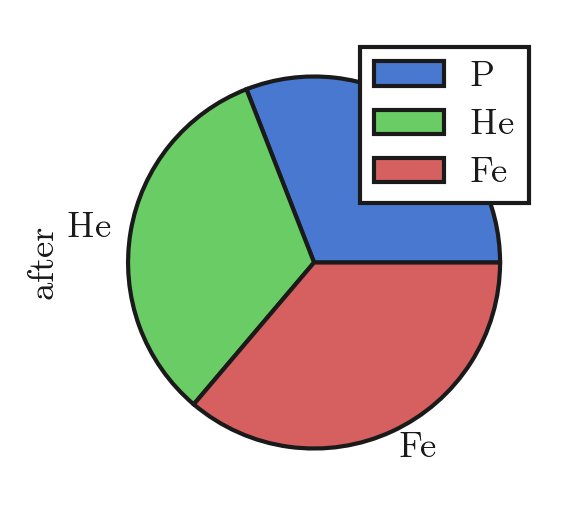

In [13]:
a = pd.DataFrame([np.sum(df.MC_comp == composition) for composition in comp_list],
                 index=comp_list, columns=['MC Compositions'])
print(a)
a.plot.pie(subplots=True, figsize=(4,4), legend=False, autopct='%.2f')
a = pd.DataFrame([np.sum(le.inverse_transform(test_predictions) == composition) for composition in comp_list], index=comp_list, columns=['after'])
print(a)
a.plot.pie(subplots=True, figsize=(2,2))

1) 0.33064538357
2) 0.187678165573
3) 0.174925540871
4) 0.159199898412
5) 0.147551011574


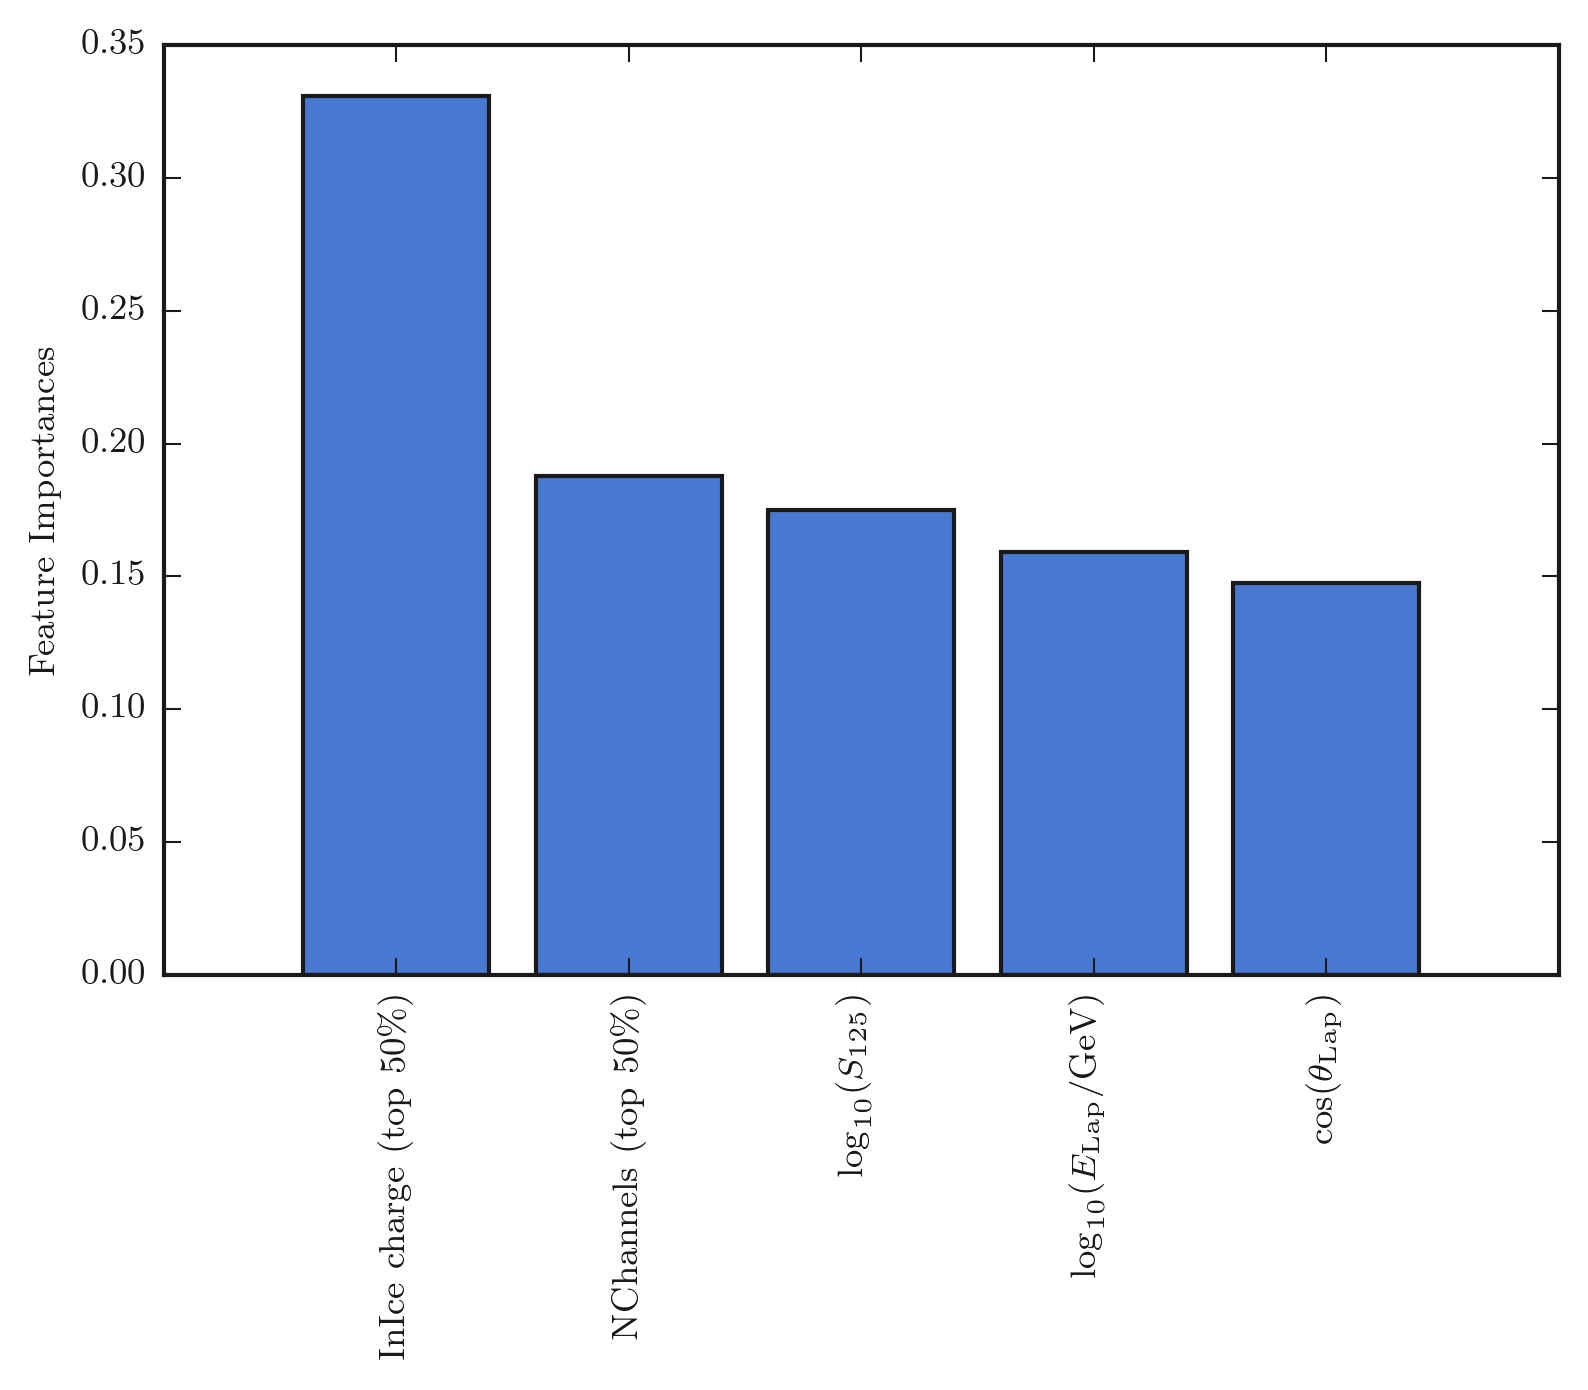

In [13]:
num_features = len(feature_list)
importances = pipeline.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[::-1]

fig, ax = plt.subplots()
# feature_labels = np.array(['$\\log_{10}({\mathrm{E/GeV})$', 'InIce charge',
#                            '$\cos(\\theta)$', '$\mathrm{Laputop}\ \chi^2/\mathrm{n.d.f.}$', 'NChannels'])
for f in range(num_features):
    print('{}) {}'.format(f + 1, importances[indices[f]]))

plt.ylabel('Feature Importances')
plt.bar(range(num_features),
        importances[indices],
        align='center')

plt.xticks(range(num_features),
           feature_labels[indices], rotation=90)
plt.xlim([-1, len(feature_list)])
# plt.ylim([0, .40])
plt.show()

In [50]:
probs = pipeline.named_steps['classifier'].predict_proba(X_test)
prob_1 = probs[:, 0][MC_iron_mask]
prob_2 = probs[:, 1][MC_iron_mask]
# print(min(prob_1-prob_2))
# print(max(prob_1-prob_2))
# plt.hist(prob_1-prob_2, bins=30, log=True)
plt.hist(prob_1, bins=np.linspace(0, 1, 50), log=True)
plt.hist(prob_2, bins=np.linspace(0, 1, 50), log=True)

NameError: name 'MC_iron_mask' is not defined

In [ ]:
probs = pipeline.named_steps['classifier'].predict_proba(X_test)
dp1 = (probs[:, 0]-probs[:, 1])[MC_proton_mask]
print(min(dp1))
print(max(dp1))
dp2 = (probs[:, 0]-probs[:, 1])[MC_iron_mask]
print(min(dp2))
print(max(dp2))
fig, ax = plt.subplots()
# plt.hist(prob_1-prob_2, bins=30, log=True)
counts, edges, pathes = plt.hist(dp1, bins=np.linspace(-1, 1, 100), log=True, label='Proton', alpha=0.75)
counts, edges, pathes = plt.hist(dp2, bins=np.linspace(-1, 1, 100), log=True, label='Iron', alpha=0.75)
plt.legend(loc=2)
plt.show()
pipeline.named_steps['classifier'].classes_

In [ ]:
print(pipeline.named_steps['classifier'].classes_)
le.inverse_transform(pipeline.named_steps['classifier'].classes_)

In [ ]:
pipeline.named_steps['classifier'].decision_path(X_test)